# Lesson 1: Introduction to Deep Learning with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

### What is PyTorch ?

### Why PyTorch ?

### Code

In [13]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

%matplotlib inline
plt.style.use('fivethirtyeight')

In [14]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

### Create the data

In [48]:
seed=1234
random.seed(seed)
torch.manual_seed(seed)
N = 1000 # num_samples_per_class
D = 2 # dimensions
C = 3 # num_classes
H = 100 # num_hidden_units

In [67]:
X = torch.zeros((N*C, D))
y = torch.zeros((N*C))
for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(i*4,(i+1)*4,N) + torch.randn(N)*0.1
    for ix in range(N*i, N*(i+1)):
        X[ix] = torch.FloatTensor(
            (r[index]*np.sin(t[index]), r[index]*np.cos(t[index])), )
        y[ix] = i
        index += 1

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([3000, 2])
y: torch.Size([3000])


In [68]:
def plot_data(X, y):
    """
    Plot the data.
    """
    plt.scatter (X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show ()

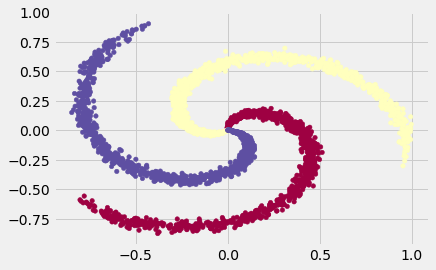

In [69]:
# Create the data
plot_data(X.numpy(), y.numpy())

### Create train/test sets

In [70]:
split_ratio = 0.8 # train-test split
num_epochs = 100
batch_size = 64
log_every = 25

In [71]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print ("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 2400 train samples and 600 test samples.


In [22]:
# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

In [23]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Processing functions

In [24]:
def process_batch(batch, model, criterion, optimizer, is_training, clipping=False):
    """
    Process a minibatch for loss and accuracy.
    """
    X_batch = batch[:,:2]
    y_batch = batch[:, 2]

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(X_batch, requires_grad=False)
    y_batch = Variable(y_batch.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        if clipping:
            # Clip the gradient norms
            nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [84]:
def train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2):
    """
    Training our model.
    """
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy    

        # Verbose
        if (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1):

            # Testing
            model.eval()
            for num_test_epoch in range(1):

                # Metrics
                test_batch_loss = 0.0
                test_batch_accuracy = 0.0

                for test_batch_num, (test_batch) in enumerate(test_loader):

                    # Get metrics
                    model.eval()
                    loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training)

                    # Add to batch scalars
                    test_batch_loss += loss.data[0] / float(len(test_batch))
                    test_batch_accuracy += accuracy

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print ("TIME REMAINING: %im %is" % (minutes, seconds))
            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    return model

In [119]:
def hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training, clipping=True)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
        if animate:
            verbose_condition = num_train_epoch == num_epochs-1
            if num_train_epoch%10 == 0:
                plot_model(X, y, model)
                display.clear_output(wait=True)
        else:
            verbose_condition = (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

        # Verbose
        if verbose_condition:

            # Testing
            model.eval()
            for num_test_epoch in range(1):

                # Metrics
                test_batch_loss = 0.0
                test_batch_accuracy = 0.0

                for test_batch_num, (test_batch) in enumerate(test_loader):

                    # Get metrics
                    model.eval()
                    loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training, clipping=True)

                    # Add to batch scalars
                    test_batch_loss += loss.data[0] / float(len(test_batch))
                    test_batch_accuracy += accuracy

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print ("TIME REMAINING: %im %is" % (minutes, seconds))
            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    return model

In [85]:
def plot_model(X, y, model):
    """
    Plot the model from torch weights.
    """
    
    X = X.numpy()
    y = y.numpy(),
    w1 = torch.transpose(model.fc1.weight.data, 0, 1).numpy()
    b1 = model.fc1.bias.data.numpy()
    w2 = torch.transpose(model.fc2.weight.data, 0, 1).numpy()
    b2 = model.fc2.bias.data.numpy()
    
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

### Linear model

In [86]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [87]:
# Linear model
class LinearModel(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z

In [89]:
# Create model
model = LinearModel(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2)

TIME REMAINING: 0m 2s
[EPOCH]: 0, [TRAIN LOSS]: 0.015575, [TRAIN ACC]: 0.472, [TEST LOSS]: 0.015879, [TEST ACC]: 0.529
TIME REMAINING: 0m 1s
[EPOCH]: 25, [TRAIN LOSS]: 0.011717, [TRAIN ACC]: 0.533, [TEST LOSS]: 0.013659, [TEST ACC]: 0.538
TIME REMAINING: 0m 1s
[EPOCH]: 50, [TRAIN LOSS]: 0.011717, [TRAIN ACC]: 0.532, [TEST LOSS]: 0.013660, [TEST ACC]: 0.538
TIME REMAINING: 0m 0s
[EPOCH]: 75, [TRAIN LOSS]: 0.011716, [TRAIN ACC]: 0.532, [TEST LOSS]: 0.013662, [TEST ACC]: 0.536
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.011716, [TRAIN ACC]: 0.532, [TEST LOSS]: 0.013664, [TEST ACC]: 0.536
LinearModel (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


LinearModel (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


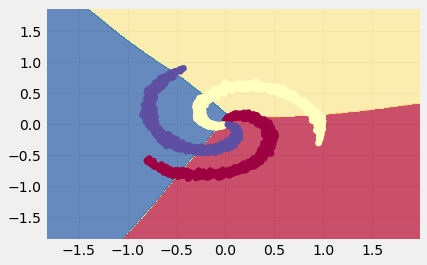

In [90]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Two-layered Network

In [29]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [30]:
# Linear model
class NN(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(NN, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        return z

In [91]:
# Create model
model = NN(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2)

TIME REMAINING: 0m 2s
[EPOCH]: 0, [TRAIN LOSS]: 0.016943, [TRAIN ACC]: 0.389, [TEST LOSS]: 0.017851, [TEST ACC]: 0.544
TIME REMAINING: 0m 2s
[EPOCH]: 25, [TRAIN LOSS]: 0.004249, [TRAIN ACC]: 0.913, [TEST LOSS]: 0.004747, [TEST ACC]: 0.914
TIME REMAINING: 0m 1s
[EPOCH]: 50, [TRAIN LOSS]: 0.001984, [TRAIN ACC]: 0.980, [TEST LOSS]: 0.002278, [TEST ACC]: 0.967
TIME REMAINING: 0m 0s
[EPOCH]: 75, [TRAIN LOSS]: 0.001218, [TRAIN ACC]: 0.991, [TEST LOSS]: 0.001453, [TEST ACC]: 0.988
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.000854, [TRAIN ACC]: 0.995, [TEST LOSS]: 0.001042, [TEST ACC]: 0.994


NN (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


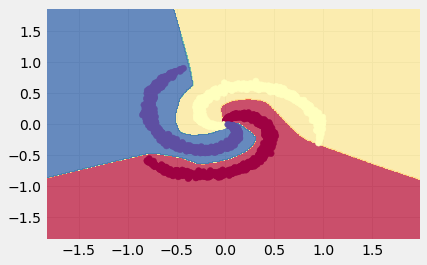

In [93]:
# Plot trained model
print (model)
plot_model(X, y, model)

-inf

### Custom Components

In [122]:
learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

In [123]:
# Linear model
class NN2(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(dropout_p)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [125]:
# Create model
model = NN2(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm)

TIME REMAINING: 0m 3s
[EPOCH]: 0, [TRAIN LOSS]: 0.017146, [TRAIN ACC]: 0.450, [TEST LOSS]: 0.018624, [TEST ACC]: 0.689
TIME REMAINING: 0m 2s
[EPOCH]: 25, [TRAIN LOSS]: 0.007789, [TRAIN ACC]: 0.752, [TEST LOSS]: 0.008321, [TEST ACC]: 0.779
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.005312, [TRAIN ACC]: 0.872, [TEST LOSS]: 0.005140, [TEST ACC]: 0.890
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.004065, [TRAIN ACC]: 0.914, [TEST LOSS]: 0.003891, [TEST ACC]: 0.920
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.003682, [TRAIN ACC]: 0.926, [TEST LOSS]: 0.003408, [TEST ACC]: 0.935


NN2 (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)


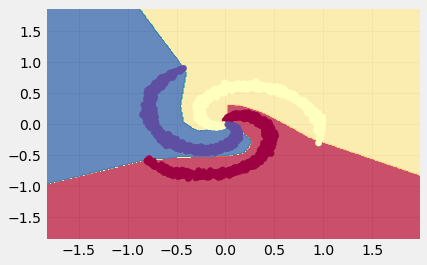

In [126]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Custom autograd

In [37]:
class ReLU(torch.autograd.Function):
    """
    Use autograd variables for implicit 
    backprop and make your own autograd 
    func. Just implemnet forward and 
    backward pass.
    """

    def forward(self, input_):
        """
        Process inputs and use
        save_for_backward to store
        inputs for backprop.
        """
        self.save_for_backward(input_)
        return input_.clamp(min=0)

    def backward(self, grad_output):
        """
        grad_output is the grad w.r.t loss.
        """
        input_, =self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_ < 0] = 0
        return grad_input

In [ ]:
# custom autograd func.
relu = ReLU()

# Forward pass
h_relu = relu(h)

...

### Save/load models

In [131]:
# Save the model
torch.save(model, os.path.join("model-NN2.pt"))

/Users/Goku/Documents/opt/venv/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type NN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [132]:
# Load the model
model = torch.load(os.path.join("model-%s.pt"%(exp_name)))

### Inference

In [108]:
X_infer = Variable(train_batch[0, :2].view(1, -1))
y_infer = Variable(train_batch[0, -1:])
print ("X_infer:\n", X_infer)
print ("y_infer:\n", y_infer)

X_infer:
 Variable containing:
 0.1173 -0.0855
[torch.FloatTensor of size 1x2]

y_infer:
 Variable containing:
 2
[torch.FloatTensor of size 1]



In [109]:
# Feed through model
model.eval()
scores = model(X_infer)
probabilities = F.softmax(scores)

# Sorted probabilities
sorted_, indices = torch.sort(probabilities, descending=True)
for i, index in enumerate(indices[0]):
    print ("%i - %i%%" % (
        indices[0].data[i],
        100.0*probabilities.data[0][index.data[0]]))

2 - 59%
0 - 35%
1 - 4%


### Hyperparameters

Let's see how changing our hyperparameters can alter the model.

TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.003735, [TRAIN ACC]: 0.917, [TEST LOSS]: 0.003392, [TEST ACC]: 0.932
NN2 (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)


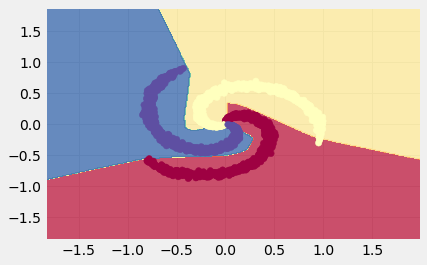

In [128]:
model = NN2(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=True)
# Plot trained model
print (model)
plot_model(X, y, model)

### Visualization / debugging